# Imports

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn as nn
import torch.nn.functional as F
import nltk
from torchtext.vocab import GloVe
from nltk import word_tokenize
import tensorflow as tf

In [69]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Connecting to Google Drive

In [70]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


# Hyperparameters

In [71]:
MAX_LEN = 16
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 32
LEARNING_RATE = 1e-3
NUM_CLASSES = 6
EPOCHS = 500

# Processing data

## Label Encoder
We used sklearn Label Encoder to encode labels to numbers. We use these numbers to turn labels into one-hot vectors.

In [72]:
le = preprocessing.LabelEncoder()
labels = ["chandler", "monica", "rachel", "phoebe", "joey", "ross"]
le.fit(labels)

LabelEncoder()

## Creating a dataframe

Using Pandas library to load csv dataset.

In [73]:
df = pd.read_csv("/content/gdrive/MyDrive/Homeworks/NLP/Project/Phase2/dialogues_cleaned.csv")
df = df.drop(df[df["person"]=="person"].index)

In [74]:
x = df["dialogue"]
y = df["person"]
y = le.transform(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [75]:
print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_test: {y_test.shape}")

x_train: (7104,)
y_train: (7104,)
x_test: (1776,)
y_test: (1776,)


## Loading GloVe vectors

In [76]:
global_vectors = GloVe(name='6B', dim=300)

# Model

## Creating a custom Dataset class

Each dialogue is tokenized and padded and turned into GloVe vectors.
Each label is changed into its one-hot form.

In [77]:
class Dataset(torch.utils.data.Dataset):    
    def __init__(self, x, y=None):          
        self.x = x.tolist()
        self.y = F.one_hot(torch.tensor(y))
     
    def __getitem__(self, idx):
        tokens = word_tokenize(self.x[idx])
        padded_tokens = tf.keras.preprocessing.sequence.pad_sequences(
            [tokens],
            dtype=object,
            maxlen=MAX_LEN,
            padding='post',
            truncating='post',
            value=""
        )
        vectors = global_vectors.get_vecs_by_tokens(padded_tokens.reshape((-1,)).tolist())
        item = {"x": vectors}
        item["texts"] = "".join(self.x[idx])
        if self.y is not None:
            item["labels"] = self.y[idx]
        return item
        
    def __len__(self):
        return len(self.x)


train_dataset = Dataset(x_train, y_train)
test_dataset = Dataset(x_test, y_test)

## Creating Dataloaders
To train the model in batch form.

In [78]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0}

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0}

training_loader = DataLoader(train_dataset, **train_params)
testing_loader = DataLoader(test_dataset, **test_params)

## Creating the model

In [79]:
class ClassificationModel(nn.Module):
    def __init__(self, num_class=6, hidden_dim=32, embed_size=300, lstm_layers=1, input_size=64, fc_size=64):
        super(ClassificationModel, self).__init__()
        self.embed_size = embed_size
        self.lstm_layers = lstm_layers
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(input_size=self.embed_size, hidden_size=self.hidden_dim, num_layers=self.lstm_layers, batch_first=True)

        self.linears = nn.Sequential(
            nn.Linear(self.hidden_dim, 64),
            nn.BatchNorm1d(64),
            nn.Tanh(),
            nn.Linear(64, num_class),
        )
        


    def forward(self, x):
        out, (hidden, cell) = self.lstm(x)
        out = out[:, -1, :] # using the last 
        out = self.linears(out)

        return F.softmax(out, dim=1)

model = ClassificationModel()

## Initializing loss function and optimizer

In [80]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=4e-5)

# Train

In [81]:
def train(dataloader, epoch):
    model.train()
    all_pred = []
    all_labels = []
    running_loss = 0
    for idx, data in enumerate(dataloader):
        text = data["x"]
        label = data["labels"]
        predicted_label = model(text)
        loss = loss_fn(predicted_label, label.float())      
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        all_pred.extend(predicted_label.argmax(1))
        all_labels.extend(label.argmax(1))
        running_loss += loss.item()
    
    iter_loss = running_loss / len(dataloader)
    return np.array(all_pred), np.array(all_labels), iter_loss


def evaluate(dataloader):
    model.eval()
    all_pred = []
    all_labels = []
    running_loss = 0
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            text = data["x"]
            label = data["labels"]
            predicted_label = model(text)
            all_pred.extend(predicted_label.argmax(1))
            all_labels.extend(label.argmax(1))
            loss = loss_fn(predicted_label, label.float())
            running_loss += loss.item()

    iter_loss = running_loss / len(dataloader)
    return np.array(all_pred), np.array(all_labels), iter_loss

In [82]:
all_tr_loss = []
all_val_loss = []
all_tr_acc = []
all_val_acc = []

for epoch in range(1, EPOCHS + 1):
    tr_pred, tr_labels, tr_loss = train(training_loader,epoch)
    val_pred, val_labels, val_loss = evaluate(testing_loader)
    tr_acc = (tr_pred == tr_labels).sum() / len(tr_pred)
    val_acc = (val_pred == val_labels).sum() / len(val_pred)

    all_tr_loss.append(tr_loss)
    all_val_loss.append(val_loss)
    all_tr_acc.append(tr_acc)
    all_val_acc.append(val_acc)

    print(
        '| end of epoch {:3d} | train loss {:5.3f} | val loss {:5.3f} | train acc {:5.3f} | val acc {:5.3f}'
        .format(epoch, tr_loss, val_loss, tr_acc, val_acc)
    )
    print('-' * 90)

| end of epoch   1 | train loss 1.789 | val loss 1.786 | train acc 0.185 | val acc 0.197
------------------------------------------------------------------------------------------
| end of epoch   2 | train loss 1.773 | val loss 1.772 | train acc 0.222 | val acc 0.212
------------------------------------------------------------------------------------------
| end of epoch   3 | train loss 1.738 | val loss 1.746 | train acc 0.267 | val acc 0.259
------------------------------------------------------------------------------------------
| end of epoch   4 | train loss 1.691 | val loss 1.714 | train acc 0.328 | val acc 0.297
------------------------------------------------------------------------------------------
| end of epoch   5 | train loss 1.645 | val loss 1.695 | train acc 0.381 | val acc 0.329
------------------------------------------------------------------------------------------
| end of epoch   6 | train loss 1.599 | val loss 1.692 | train acc 0.439 | val acc 0.341
-----------

In [83]:
torch.save(model, "/content/gdrive/MyDrive/Homeworks/NLP/Project/Phase2/Models/simple_model.pt")

# Results

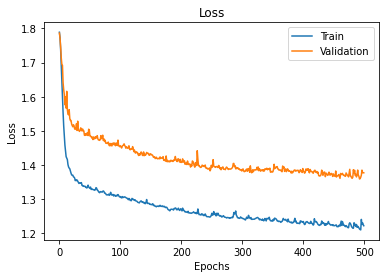

In [84]:
plt.plot(all_tr_loss, label='Train')
plt.plot(all_val_loss, label='Validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

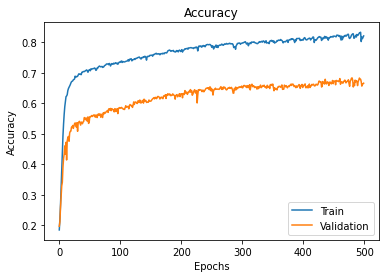

In [85]:
plt.plot(all_tr_acc, label='Train')
plt.plot(all_val_acc, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [86]:
def get_reports(y_true, y_pred, mode, labels=labels):
    cr = classification_report(y_true, y_pred, target_names=labels)
    cm = confusion_matrix(y_true, y_pred)

    print(f'\nClassification Report {mode}')
    print(cr)

    print(f'Confusion Matrix {mode}')
    print(cm)

    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest')
    plt.colorbar()
    tick_mark = np.arange(len(labels))
    _ = plt.xticks(tick_mark, labels, rotation=90)
    _ = plt.yticks(tick_mark, labels)


Classification Report Train
              precision    recall  f1-score   support

    chandler       0.82      0.85      0.84      1273
      monica       0.76      0.86      0.81      1113
      rachel       0.84      0.82      0.83      1207
      phoebe       0.84      0.81      0.83      1050
        joey       0.83      0.82      0.82      1196
        ross       0.84      0.77      0.80      1265

    accuracy                           0.82      7104
   macro avg       0.82      0.82      0.82      7104
weighted avg       0.82      0.82      0.82      7104

Confusion Matrix Train
[[1087   54   39   25   36   32]
 [  36  957   29   22   47   22]
 [  41   64  986   32   40   44]
 [  33   64   39  852   29   33]
 [  53   63   23   28  981   48]
 [  77   56   59   52   51  970]]


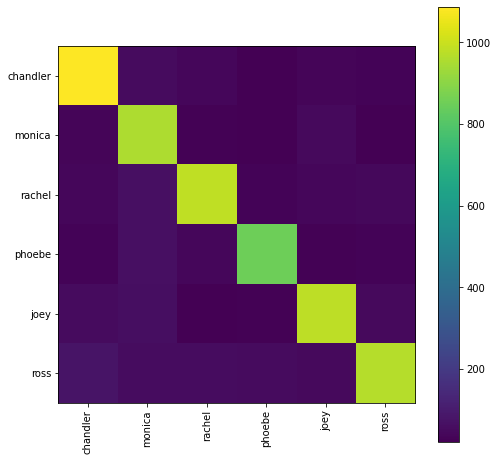

In [87]:
get_reports(tr_labels, tr_pred, mode="Train", labels=labels)


Classification Report Validation
              precision    recall  f1-score   support

    chandler       0.71      0.72      0.71       305
      monica       0.56      0.71      0.63       269
      rachel       0.73      0.62      0.67       315
      phoebe       0.70      0.68      0.69       252
        joey       0.63      0.67      0.65       342
        ross       0.72      0.61      0.66       293

    accuracy                           0.67      1776
   macro avg       0.67      0.67      0.67      1776
weighted avg       0.67      0.67      0.67      1776

Confusion Matrix Validation
[[220  25  20   6  17  17]
 [ 16 191  13  13  30   6]
 [ 18  35 194  13  40  15]
 [ 11  25  13 171  18  14]
 [ 25  43  11  17 228  18]
 [ 21  23  15  26  29 179]]


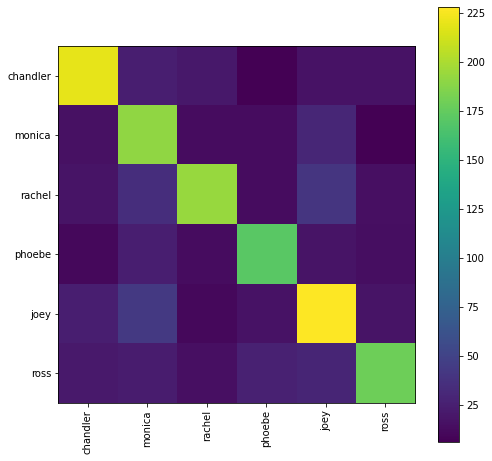

In [88]:
get_reports(val_labels, val_pred, mode="Validation", labels=labels)

In [89]:
batch_data = next(iter(testing_loader))
texts = batch_data["texts"]
texts_vec = batch_data["x"]
labels = batch_data["labels"]

preds = model(texts_vec)
y_preds = preds.argmax(1)
y_trues = labels.argmax(1)

y_preds_label = le.inverse_transform(y_preds)
y_trues_label = le.inverse_transform(y_trues)

for text, y_pred, y_true in zip(texts, y_preds_label, y_trues_label):
    print(text)
    print(f"P: {y_pred}")
    print(f"T: {y_true}")
    print("-" * 25)

bill colleen
P: chandler
T: chandler
-------------------------
mhmm
P: rachel
T: monica
-------------------------
sure
P: rachel
T: rachel
-------------------------
pleasethese guyswe havent even moved yet picking china patterns mike seems gag littleand laughs nervously begin leave phoebe bolts back
P: phoebe
T: phoebe
-------------------------
dont sing sit pass judgments others
P: monica
T: monica
-------------------------
whats matter
P: joey
T: rachel
-------------------------
look ross hes sandy sensitive thats
P: rachel
T: rachel
-------------------------
mikes
P: phoebe
T: phoebe
-------------------------
know mine
P: monica
T: monica
-------------------------
know dont mind male nanny draw line male wetnurse laugh even fake
P: chandler
T: chandler
-------------------------
weird think hes gross yet youre willing eat crackers mike desperately tries get rid crackers mouth uses hand clean tongue
P: phoebe
T: phoebe
-------------------------
going next argument
P: phoebe
T: ross
--